In [1]:
import os

In [2]:
import time

In [3]:
import tensorflow

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Input, Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input,\
 decode_predictions
from tensorflow.keras.applications import ResNet50

In [7]:
from tensorflow.keras.models import clone_model

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
import seaborn as sns
sns.set(font_scale=1.5)

In [11]:
from PIL import Image

In [12]:
from tqdm import tqdm

In [13]:
extract_dir = "/data/dogs-extract-10"

In [14]:
width, height = 230, 230

In [15]:
batch_size = 16

In [16]:
def dir_to_datasets(directory):
    """Read images from directory, resize them, perform
    data augmentation on the training set and return trainable datasets"""
    data_train = image_dataset_from_directory(extract_dir, validation_split=0.2, subset="training", 
                                              seed=42, image_size=(height, width), batch_size=batch_size, 
                                              )
    
    data_val = image_dataset_from_directory(extract_dir, validation_split=0.2, subset="validation",
                                            seed=42, image_size=(height, width), batch_size=batch_size,
                                            )    
    
    class_names = data_train.class_names
    assert len(data_train.class_names) == len(data_val.class_names)
    nb_classes = len(class_names)
    
    data_train = data_train.prefetch(buffer_size=64)
    data_val = data_val.prefetch(buffer_size=64)

    return data_train, data_val, class_names, nb_classes
    

In [17]:
data_train, data_val, class_names, nb_breeds = dir_to_datasets(extract_dir)

Found 2233 files belonging to 10 classes.
Using 1787 files for training.
Found 2233 files belonging to 10 classes.
Using 446 files for validation.


2022-07-28 20:25:16.961968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 20:25:16.967933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 20:25:16.968084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 20:25:16.968621: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [18]:
class_names

['Afghan_hound',
 'Bernese_mountain_dog',
 'Great_Pyrenees',
 'Irish_wolfhound',
 'Leonberg',
 'Maltese_dog',
 'Pomeranian',
 'Samoyed',
 'Scottish_deerhound',
 'Shih-Tzu']

In [19]:
nb_breeds

10

In [20]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
model = VGG16(include_top=False, input_shape=(height, width, 3))

In [23]:
# stop .fit from training all layers : we use transfer learning, it makes
# no sense 

In [24]:
for layer in model.layers:
    layer.trainable = False

In [25]:
# we add output layer that matches our requirement

In [26]:
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(nb_breeds, activation='softmax')(class1)

In [27]:
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 230, 230, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 230, 230, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 230, 230, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 115, 115, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 115, 115, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 115, 115, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

In [28]:
### the VGG16 parameters are non-trainable ; the parameters from the
### layers we added are trainable

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 230, 230, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 230, 230, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 230, 230, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 115, 115, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 115, 115, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 115, 115, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

In [30]:
# all params are trainable : because we are building from scratch, no transfer learning

In [31]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
callback = EarlyStopping(monitor='loss', patience=3, min_delta=1e-4)

In [33]:
# prepare training
epochs = 10
batch_size = 8

In [34]:
# fit on original images

t_fit_0 = time.time()
model_info = model.fit(
    data_train, validation_data=data_val,
    epochs=epochs, callbacks = [callback]
)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

Epoch 1/10


2022-07-28 20:25:20.564796: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


  5/112 [>.............................] - ETA: 4s - loss: 34.5525 - accuracy: 0.2000     

2022-07-28 20:25:24.057417: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


112/112 [==============================] - 14s 80ms/step - loss: 10.5343 - accuracy: 0.6094 - val_loss: 7.4414 - val_accuracy: 0.6547
Epoch 2/10
112/112 [==============================] - 5s 48ms/step - loss: 0.9481 - accuracy: 0.9351 - val_loss: 5.4568 - val_accuracy: 0.7265
Epoch 3/10
112/112 [==============================] - 5s 48ms/step - loss: 0.1989 - accuracy: 0.9793 - val_loss: 6.1646 - val_accuracy: 0.7287
Epoch 4/10
112/112 [==============================] - 5s 48ms/step - loss: 0.1214 - accuracy: 0.9843 - val_loss: 6.3672 - val_accuracy: 0.7242
Epoch 5/10
112/112 [==============================] - 5s 49ms/step - loss: 0.1062 - accuracy: 0.9871 - val_loss: 6.4649 - val_accuracy: 0.7466
Epoch 6/10
112/112 [==============================] - 5s 48ms/step - loss: 0.0888 - accuracy: 0.9899 - val_loss: 9.3045 - val_accuracy: 0.7063
Epoch 7/10
112/112 [==============================] - 5s 48ms/step - loss: 0.2958 - accuracy: 0.9743 - val_loss: 7.9229 - val_accuracy: 0.7130
Epoch 8/

In [35]:
epochs = len(model_info.history["accuracy"])

In [36]:
def plot_acc_loss(model_info, epochs):
    """Common plots for accuracy and loss wrt epochs"""
    acc = model_info.history['accuracy']
    val_acc = model_info.history['val_accuracy']

    loss = model_info.history['loss']
    val_loss = model_info.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

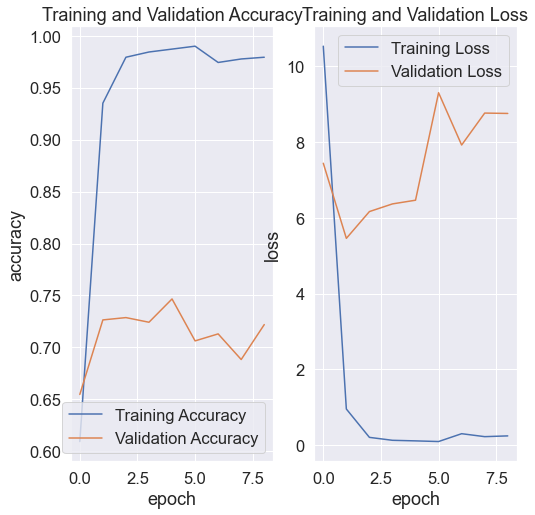

In [37]:
plot_acc_loss(model_info, epochs)

In [38]:
tensorflow.keras.backend.clear_session()


In [39]:
# test model on image of Afghan hound taken from Wikipedia

In [40]:
def predict_one_image(path):
    one_image = Image.open(path)
    one_image = one_image.resize((height, width))
    one_image = tensorflow.convert_to_tensor([np.array(one_image)])
    idx_max = model.predict(one_image)[0].argmax()
    return class_names[idx_max]
    

In [41]:
predict_one_image("/data/dogs-test/Afghan_dog_-_cropped.jpg")

'Afghan_hound'

In [42]:
predict_one_image("/data/dogs-test/480px-Maltese_600.jpg")


'Maltese_dog'

In [43]:
data_val = image_dataset_from_directory(extract_dir, validation_split=0.2, subset="validation",
                                            seed=42, image_size=(height, width), batch_size=batch_size,
                                            )

Found 2233 files belonging to 10 classes.
Using 446 files for validation.


In [44]:
predicted = []
labels = []
for file in tqdm(data_val.file_paths):
    prediction = predict_one_image(file)
    label = file.split("/")[3]

    predicted.append(prediction)
    labels.append(label)

100% 446/446 [00:36<00:00, 12.26it/s]


In [45]:
m = confusion_matrix(predicted, labels)
m = pd.DataFrame(m)

In [46]:
m.columns = class_names
m.index = class_names

<AxesSubplot:>

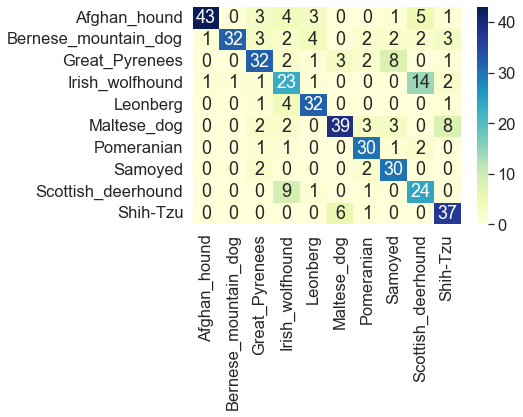

In [47]:
sns.heatmap(m, annot=True, fmt='.0f', cmap='YlGnBu')